In [29]:
!pip3 install matplotlib nltk ftfy pandas scikit-learn tensorflow keras
!pip3 install gensim==3.8.0

import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import WordPunctTokenizer
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tok = WordPunctTokenizer()
plt.style.use('fivethirtyeight')

Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Would remove:
    /Users/sriramp/Library/Python/3.9/lib/python/site-packages/matplotlib-3.7.1-py3.9-nspkg.pth
    /Users/sriramp/Library/Python/3.9/lib/python/site-packages/matplotlib-3.7.1.dist-info/*
    /Users/sriramp/Library/Python/3.9/lib/python/site-packages/matplotlib/*
    /Users/sriramp/Library/Python/3.9/lib/python/site-packages/mpl_toolkits/axes_grid1/*
    /Users/sriramp/Library/Python/3.9/lib/python/site-packages/mpl_toolkits/axisartist/*
    /Users/sriramp/Library/Python/3.9/lib/python/site-packages/mpl_toolkits/mplot3d/*
    /Users/sriramp/Library/Python/3.9/lib/python/site-packages/pylab.py
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Found existing installation: gensim 3.8.0
Uninstalling gensim-3.8.0:
  Would remove:
    /Users/sriramp/Library/Python/3.9/lib/python/site-packages/gensim-3.8.0.dist-info/*
    /Users/sriramp/Library/Python/3.9/lib/python/site-packages/gensim/*
Proceed (

In [ ]:
np.random.seed(1234)

DEPRES_NROWS = 15000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 280 # Max tweet size
MAX_NB_WORDS = 25000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.5
EPOCHS= 20

In [ ]:
#DEPRESSIVE_TWEETS_CSV = 'depressive_tweets.csv'
DEPRESSIVE_TWEETS_CSV = 'vader_processed_final.csv'
RANDOM_TWEETS_CSV = 'Sentiment Analysis Dataset 2.csv'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [ ]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, usecols = range(1,5), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [ ]:
depressive_tweets_df.head()

,Unnamed: 0,vader_sentiment_label,vader_score,clean_tweet
0,NaN,0,-0.4941,Listen!! IM SORRY!! With elder spirits gone di...
1,NaN,0,-0.8176,Im pissed depressed time
2,NaN,0,0.0000,"I’m hot mess that’s stressed, depressed, poorl..."
3,NaN,0,-0.5106,Chen's probably depressed since longer shikiga...
4,NaN,1,0.3270,"Do like I shake ya, daddy? Move around? Let ge..."


In [ ]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [ ]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)


In [ ]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links then dont append to avoid news articles
        # also check tweet length, save those > 10 (length of word "depression")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #remove hashtag, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            
            #expand contraction
            tweet = expandContractions(tweet)

            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            #stop words
            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [ ]:
import nltk
nltk.download('stopwords')
depressive_tweets_arr = [x for x in depressive_tweets_df['clean_tweet']]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

[nltk_data] Downloading package stopwords to /home/sriram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [ ]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 33456 unique tokens


In [ ]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (14019, 280)
Shape of data_r tensor: (11911, 280)


In [ ]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.wv.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [ ]:
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [ ]:
from keras import optimizers
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
nadam = optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 300)          7500000   
                                                                 
 conv1d_1 (Conv1D)           (None, 280, 32)           28832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 140, 32)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 140, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 300)               399600    
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                      

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=16, shuffle=True, \
                callbacks=[early_stop]
        )
# hist = model.fit(data_train, labels_train, \
#         validation_data=(data_val, labels_val), \
#         epochs=EPOCHS, batch_size=16, shuffle=True,
#         )

Epoch 1/2000
973/973 [==============================] - 140s 143ms/step - loss: 0.1244 - acc: 0.9532 - val_loss: 0.3097 - val_acc: 0.8940
Epoch 2/2000
973/973 [==============================] - 139s 143ms/step - loss: 0.1228 - acc: 0.9507 - val_loss: 0.3048 - val_acc: 0.8932
Epoch 3/2000
973/973 [==============================] - 136s 140ms/step - loss: 0.1217 - acc: 0.9512 - val_loss: 0.3021 - val_acc: 0.8911
Epoch 4/2000
973/973 [==============================] - 130s 134ms/step - loss: 0.1174 - acc: 0.9531 - val_loss: 0.3192 - val_acc: 0.8911
Epoch 5/2000
973/973 [==============================] - 120s 123ms/step - loss: 0.1113 - acc: 0.9567 - val_loss: 0.3571 - val_acc: 0.8918
Epoch 6/2000
973/973 [==============================] - 135s 138ms/step - loss: 0.1150 - acc: 0.9549 - val_loss: 0.3486 - val_acc: 0.8951


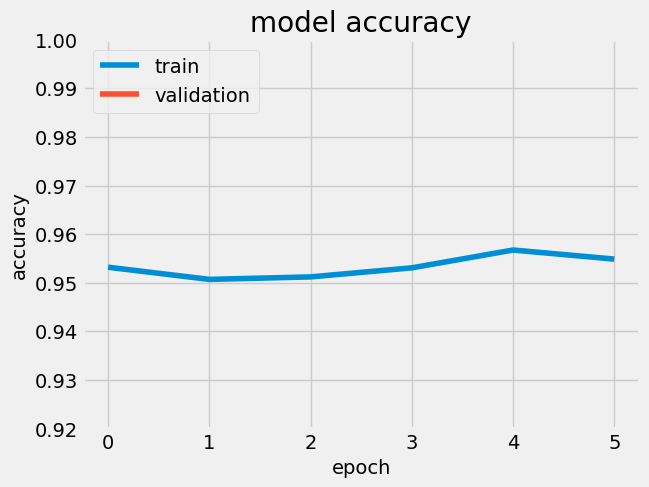

In [ ]:

#Results: summarize the history for accuracy
# plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.ylim(.92,1)
# plt.show()
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(.92,1)
plt.show()

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

163/163 [==============================] - 9s 47ms/step
Accuracy: 88.97%


In [ ]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2382
           1       0.93      0.86      0.89      2804

    accuracy                           0.89      5186
   macro avg       0.89      0.89      0.89      5186
weighted avg       0.89      0.89      0.89      5186



In [ ]:

def find(input):
    input = [input]
    sequences_d = tokenizer.texts_to_sequences(input)
    data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
    k = model.predict(data_d)
    print(k)

In [ ]:

find('Beauty is everywhere. You only have to look to see it.')

find('I feel so lonely and so melancholy. I feel like I’m in the wrong place.')


find('Sometimes, you have to make a decision that will break your heart, but will give peace to your soul.')




1/1 [==============================] - 0s 29ms/step
[[0.0054556]]
1/1 [==============================] - 0s 32ms/step
[[0.462566]]
1/1 [==============================] - 0s 25ms/step
[[0.05408667]]


In [ ]:
from tensorflow import keras
mode = keras.models.load_model("final.h5")
input = ['I feel so lonely and so melancholy. I feel like I’m in the wrong place.']
sequences_d = tokenizer.texts_to_sequences(input)
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
k = mode.predict(data_d)
print(k)

1/1 [==============================] - 0s 245ms/step
[[0.473464]]


In [ ]:
import h5py


model.save('final.pt')
model.save('final.h5')

# save_model(
#     model,
#     "keras.h5",
#     overwrite=True,
#     include_optimizer=True
# )

json_string = model.to_json()
# yaml_string = model.to_yaml()

import tensorflowjs as tfjs
# from tensorflow.python.keras.models import Input

tfjs.converters.save_keras_model(model, "keras.h5",)

INFO:tensorflow:Assets written to: final.pt/assets


INFO:tensorflow:Assets written to: final.pt/assets


In [ ]:
import pandas as pd
from flask import Flask, jsonify, render_template, request
app = Flask(__name__)
# model = keras.models.load_model("final.h5")
@app.route("/", methods=["GET", "POST"])
def home():
    if request.method == "POST":
        def find(input):
            sequences_d = tokenizer.texts_to_sequences(input)
            data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
            k = model.predict(data_d)
            
            m = k[0][0]
            print("predicted",m)
            return m
        print(request.form["name"])
        val = find(request.form["name"])
        print(val)
        return render_template('home.html', value=val)
    return render_template("home.html")

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


I feel so lonely and so melancholy. I feel like I’m in the wrong place.
3/3 [==============================] - 0s 31ms/step


127.0.0.1 - - [01/Apr/2023 09:51:59] "POST / HTTP/1.1" 200 -


predicted 0.15831994
STRESS
Beauty is everywhere. You only have to look to see it.
2/2 [==============================] - 0s 34ms/step


127.0.0.1 - - [01/Apr/2023 09:52:03] "POST / HTTP/1.1" 200 -


predicted 0.7016203
HAPPY
Sometimes, you have to make a decision that will break your heart, but will give peace to your soul.
4/4 [==============================] - 0s 33ms/step


127.0.0.1 - - [01/Apr/2023 09:52:07] "POST / HTTP/1.1" 200 -


predicted 0.40611377
STRESS
Beauty is everywhere. You only have to look to see it.
2/2 [==============================] - 0s 32ms/step


127.0.0.1 - - [01/Apr/2023 10:04:28] "POST / HTTP/1.1" 200 -


predicted 0.7016203
HAPPY
Sometimes, you have to make a decision that will break your heart, but will give peace to your soul.
4/4 [==============================] - 0s 33ms/step


127.0.0.1 - - [01/Apr/2023 10:04:34] "POST / HTTP/1.1" 200 -


predicted 0.40611377
STRESS
I'm too loaded. I'm unable to manage my situation. I'm sad. 
2/2 [==============================] - 0s 43ms/step


127.0.0.1 - - [01/Apr/2023 10:04:58] "POST / HTTP/1.1" 200 -


predicted 0.15831994
STRESS
i hate it when i’m so excited for something but it ends up not happening
3/3 [==============================] - 0s 29ms/step


127.0.0.1 - - [01/Apr/2023 10:10:53] "POST / HTTP/1.1" 200 -


predicted 0.15831994
STRESS
it’s hurting me but nvm.
1/1 [==============================] - 0s 57ms/step


127.0.0.1 - - [01/Apr/2023 10:11:10] "POST / HTTP/1.1" 200 -


predicted 0.15831994
STRESS
You think you can hurt me?  I'm an overthinker, I hurt myself
2/2 [==============================] - 0s 41ms/step


127.0.0.1 - - [01/Apr/2023 10:11:27] "POST / HTTP/1.1" 200 -


predicted 0.17568113
STRESS
i hate it when i’m so excited for something but it ends up not happening.
3/3 [==============================] - 0s 30ms/step


127.0.0.1 - - [01/Apr/2023 10:12:31] "POST / HTTP/1.1" 200 -


predicted 0.15831994
STRESS
I feel such a temporary person in everyone's life
2/2 [==============================] - 0s 38ms/step


127.0.0.1 - - [01/Apr/2023 10:15:05] "POST / HTTP/1.1" 200 -


predicted 0.15831994
STRESS
accept your loneliness you are your only friend
2/2 [==============================] - 0s 24ms/step


127.0.0.1 - - [01/Apr/2023 10:17:16] "POST / HTTP/1.1" 200 -


predicted 0.7910853
HAPPY
accept your loneliness you are your only friend
2/2 [==============================] - 0s 24ms/step


127.0.0.1 - - [01/Apr/2023 10:17:24] "POST / HTTP/1.1" 200 -


predicted 0.7910853
HAPPY
saw this tweet on twitter lmao this is so funny yet sad
2/2 [==============================] - 0s 36ms/step


127.0.0.1 - - [01/Apr/2023 10:18:20] "POST / HTTP/1.1" 200 -


predicted 0.40611377
STRESS
If you feel sad, listen to Rickey Smiley I swear I be dying laughing
3/3 [==============================] - 0s 26ms/step


127.0.0.1 - - [01/Apr/2023 10:18:59] "POST / HTTP/1.1" 200 -


predicted 0.15831994
STRESS
Why is it sooo hard to find a decent partner in this day and age 30 years and still not met  my soul mate
4/4 [==============================] - 0s 31ms/step


127.0.0.1 - - [01/Apr/2023 10:21:13] "POST / HTTP/1.1" 200 -


predicted 0.32235736
STRESS
I feel such a temporary person in everyone's life
2/2 [==============================] - 0s 24ms/step


127.0.0.1 - - [01/Apr/2023 10:23:37] "POST / HTTP/1.1" 200 -


predicted 0.15831994
STRESS
Why is it sooo hard to find a decent partner in this day and age 30 years and still not met  my soul mate
4/4 [==============================] - 0s 32ms/step


127.0.0.1 - - [01/Apr/2023 10:25:45] "POST / HTTP/1.1" 200 -


predicted 0.32235736
STRESS
